# The `ImageClassified` class
In this chapter, we will take a look at the `ImageClassified` class, which allows us to make sense of the light/dark/background classification from the previous section. More specifically, for laminated sediments, we would like a stripy classification, as each stripe represents a certain time period. 

## Instantiating the `ImageClassified` class
The introduction of the `Descriptor` was a slight detour from the `ImageSample`-`ImageROI`-`ImageClassified` workflow, but now we will get back to that. The big advantage of correcting the tilts first is that it is a lot easier to define layers. We only need to define the start and end of each layer instead of some bendy shapes (as was done previously and is now considered legacy)

Initialization is similar to the `ImageROI` class, so you can either provide
* an `image`, `obj_color` and `image_classification`
* a `path_image_file`, `obj_color` and `image_classification`
* a parent instance and call `from_parent`
We will go with the last version, so we don't have to worry about any of the other parameters. By default, the `ImageClassified` class will assume that a tilt-correction is to be performed (if this is not the case, set `use_tilt_correction=False` for the initialization).

In [1]:
from maspim import ImageClassified, ImageROI

path_folder = 'Data'

roi = ImageROI.from_disk(path_folder)
classified = ImageClassified.from_parent(roi)

## Setting the tilt correction
The class is structured in such a way, that it will create a new tilt correcter automatically if it does not exist yet. As we saw above, it is better to have a bit more control over the parameters, so we will call the *set_corrected_image* method, this time for the example from the ImageROI chapter:

setting unique values: 100%|████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 315.35it/s]


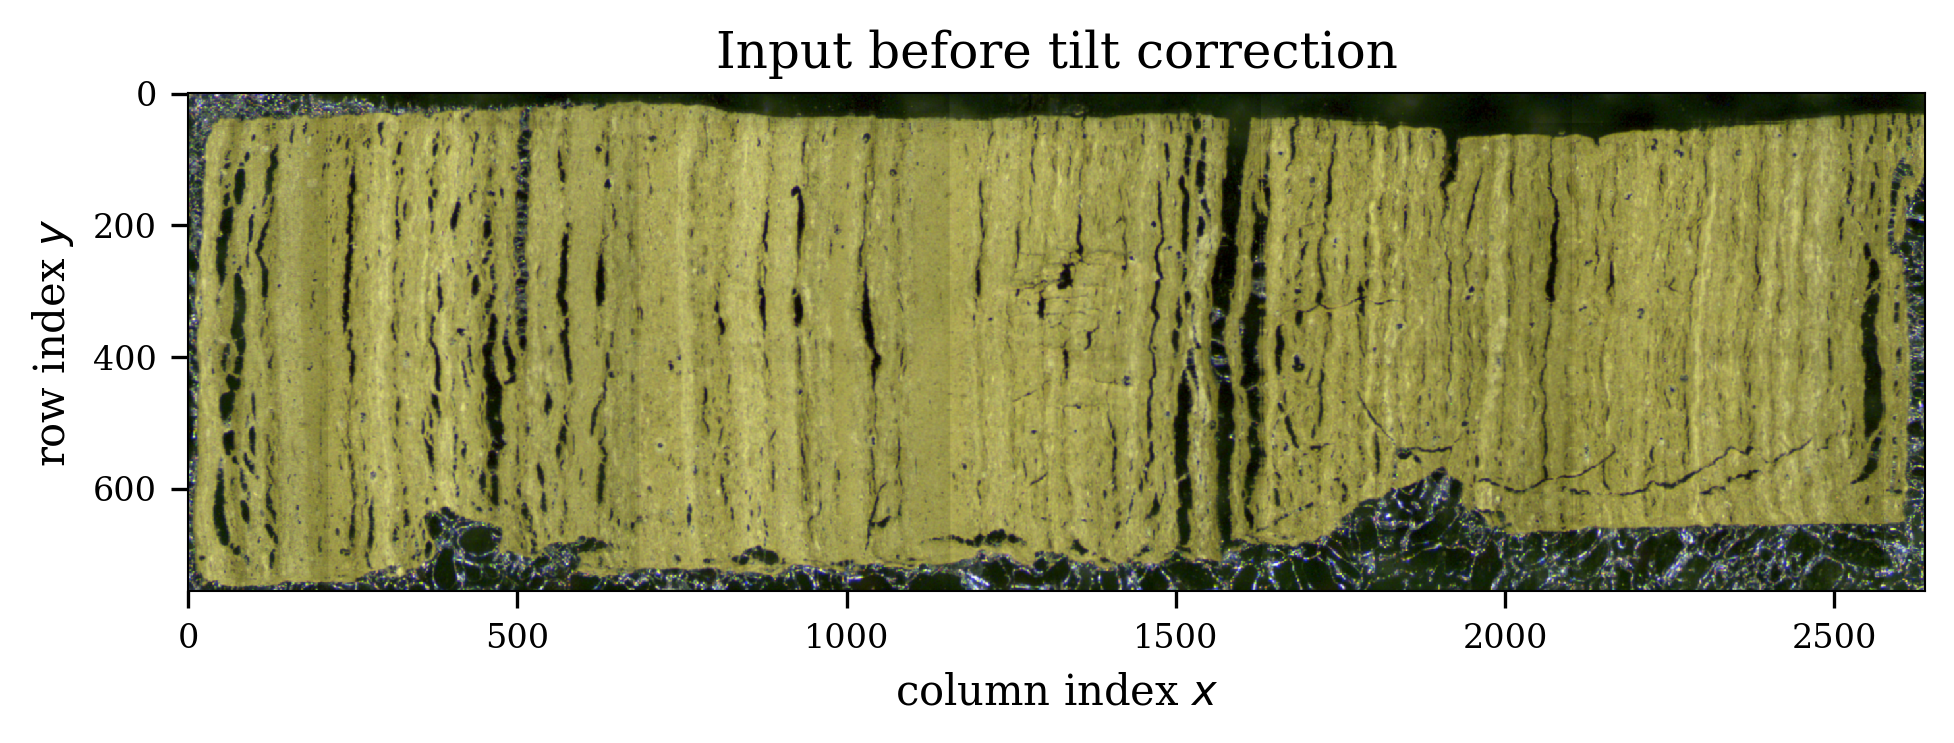

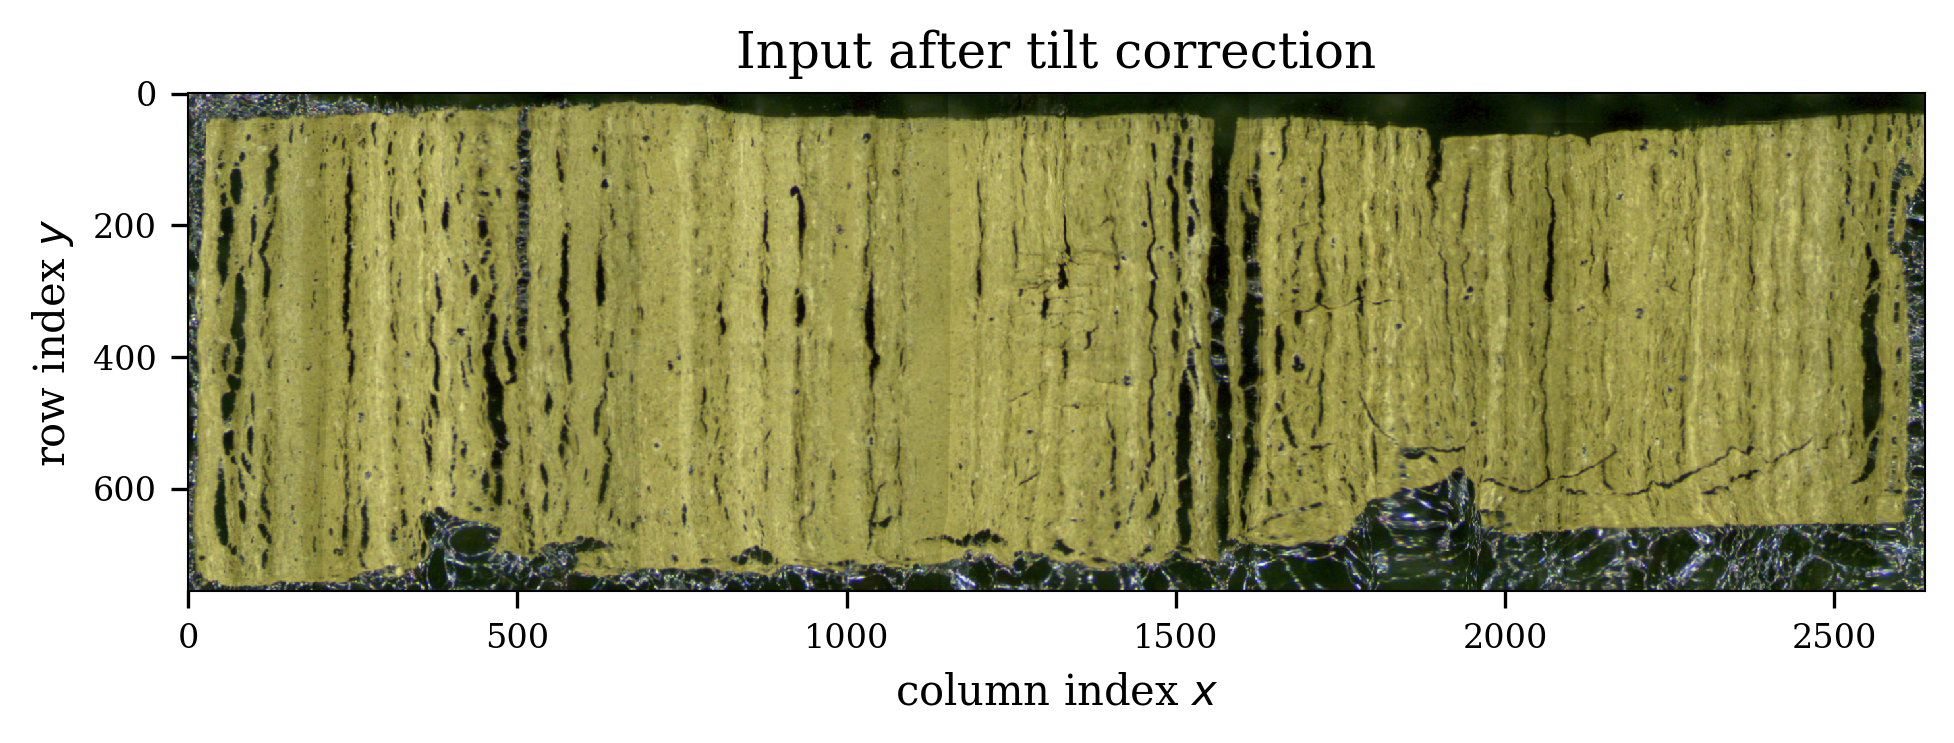

In [2]:
import math
%matplotlib inline
classified.set_corrected_image(angles_min=math.radians(-22.5), angles_max=math.radians(22.5), mute_bounds=.1)

classified.use_tilt_correction = False
classified.plot(title='Input before tilt correction')

classified.use_tilt_correction = True
classified.plot(title='Input after tilt correction')

Here the differences are rather subtle, but overall we can see a small improvement.

## Identifying individual layers
Now we will identify individual layers, using the light/dark/background classification from the `ImageROI` class. This will happen through multiple steps
1. identify *seeds*, for layers (ideally middle points, we will detect them as extremal values in the averaged brightness signal)
2. find the exact extent of each layer around its seed
3. calculate diagnostic parameters (such as the quality) and filter out bad layers

### Seed setting
The goal of the seed picking is to find possible *candidates* for layers. At this stage we don't care too much about getting every layer correct, relying on the fact that superfluous layers will be filtered out downstream. But filtering early on makes the analysis faster, so we will use a value that ensures we still have enough seeds

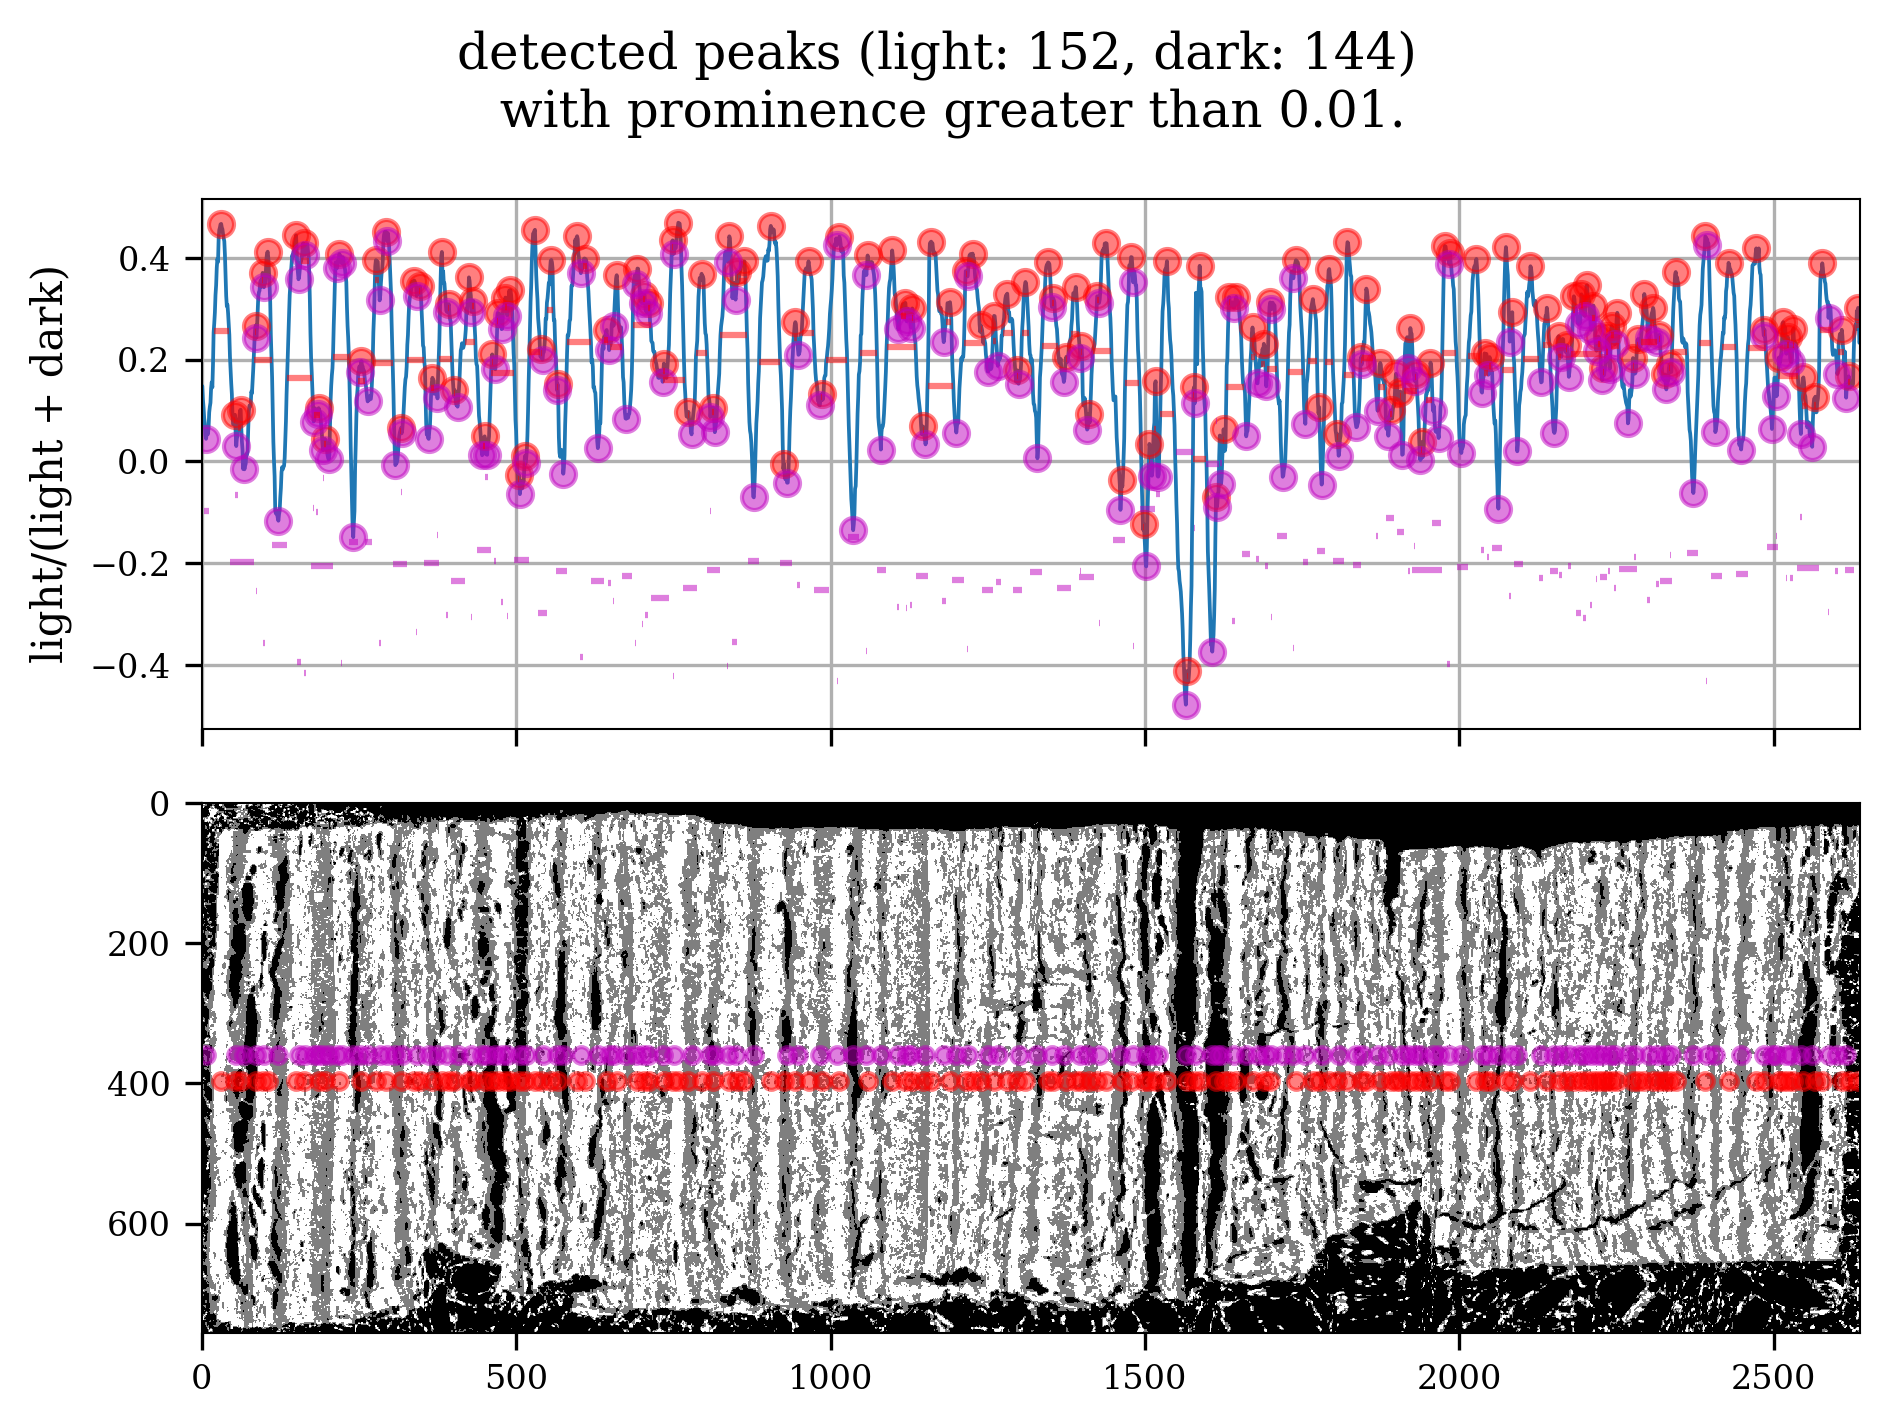

In [3]:
classified.set_seeds(plts=True, peak_prominence=.01)

So here we get about twice as many layers as we would expect according to the age model. 

### Determining laminae parameters
To appreciate the tilt correction we will first look at the legacy method (or don't as this may take a while):

In [4]:
if False:  # change this to True if you want to see the result
    classified.use_tilt_correction = False
    classified.set_params_laminae_simplified()
    classified.set_quality_score()
    classified.set_laminae_images_from_params()
    classified.plot_image_seeds_and_classification()

We can see some crossing layers, which is not even that bad in this case, but it tends to happen often with this method. So now let's look at the improved method:

Setting simplified laminae: 100%|███████████████████████████████████████████████████| 296/296 [00:01<00:00, 179.40it/s]


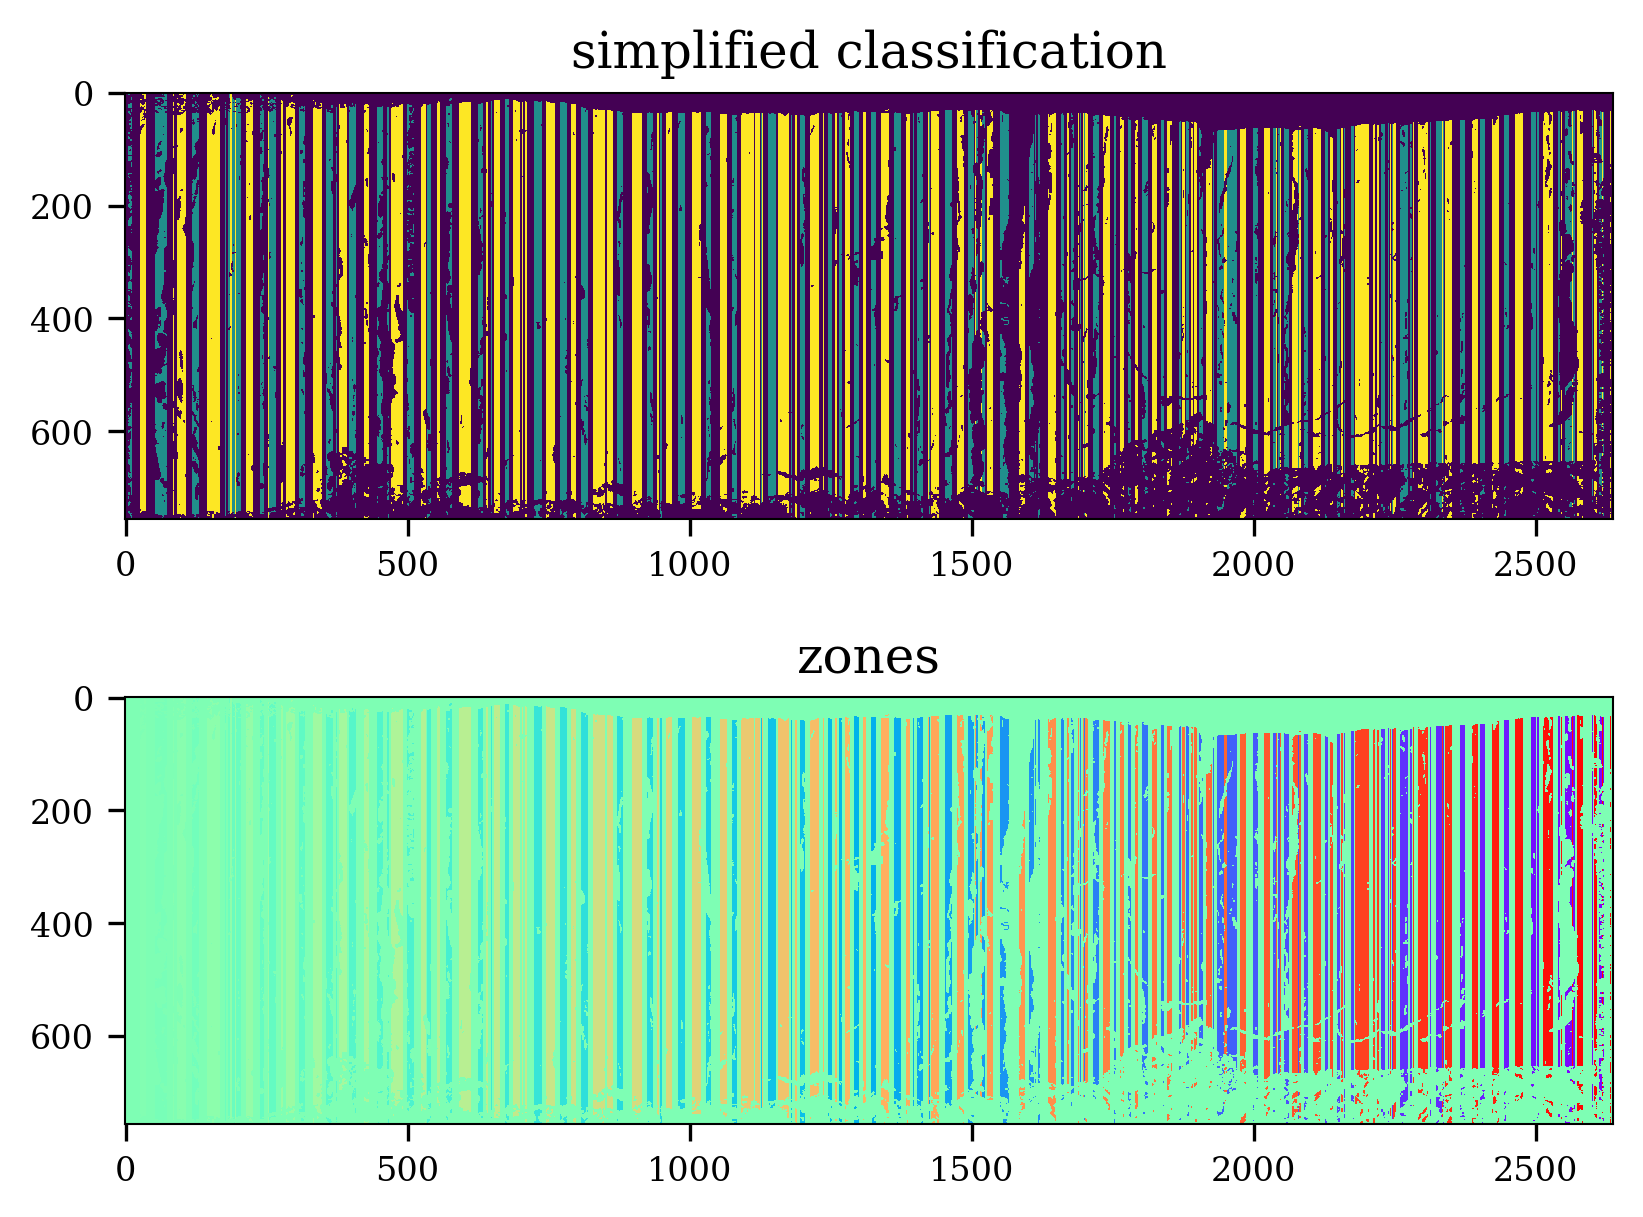

In [5]:
classified.use_tilt_correction = True
classified.set_seeds(peak_prominence=.01)
classified.set_params_laminae_simplified()
classified.set_quality_score()
classified.set_laminae_images_from_params()
classified.plot_image_seeds_and_classification()

In [6]:
classified.params_laminae_simplified

seed    a    b    c             d     height  success  color      width  \
0       7  0.0  0.0  0.0  5.394035e-03  13.575843    False   dark   8.524922   
1      31  0.0  0.0  0.0  2.449480e-03  25.649092    False  light  24.554190   
2      53  0.0  0.0  0.0  0.000000e+00   1.384219     True  light   1.384219   
3      55  0.0  0.0  0.0  2.543883e-03   7.692702     True   dark   3.846351   
4      62  0.0  0.0  0.0  3.572790e-03   2.701029     True  light   5.402059   
..    ...  ...  ...  ...           ...        ...      ...    ...        ...   
291  2601  0.0  0.0  0.0  5.802380e-04   6.365751    False   dark   4.889269   
292  2608  0.0  0.0  0.0 -1.706159e-03   7.682542    False  light   8.156567   
293  2615  0.0  0.0  0.0  9.238128e-03  15.970760     True   dark  13.968050   
294  2619  0.0  0.0  0.0  1.431341e-03   1.082094     True  light   2.164187   
295  2634  0.0  0.0  0.0 -6.466960e-14   5.369036    False  light   4.130511   

     prominence  homogeneity  continuity  brightness  contrast   quality  
0      0.103529    -0.770115    0.424861    0.439269 -0.151426  0.049545  
1      0.422139     0.806093    0.966308    0.596042  0.461467  0.359452  
2      0.018936     0.000000    0.000000    0.000000 -1.000000 -0.000000  
3      0.071341    -0.494684    0.537841    0.475130  0.347902 -0.092563  
4      0.071341    -0.488722    0.705570    0.459723 -0.008018  0.002765  
..          ...          ...         ...         ...       ...       ...  
291    0.086867    -0.268903    0.839218    0.455852  0.320708 -0.072374  
292    0.086867    -0.003471    0.713477    0.468925  0.014597 -0.000036  
293    0.176394    -0.384034    0.374160    0.455013 -0.006955  0.000999  
294    0.022649    -0.325758    0.366667    0.453849 -0.029324  0.003503  
295    0.068717     0.197256    0.403181    0.507527  0.055835  0.004441  

[296 rows x 15 columns]

We see that layers are no longer crossing, but the number of layers is way too big, so let's reduce them to a reasonable amount. Here, we are lucky that an age model exists, which tells us that we are expecting around 100 layers. 

Calculating layer qualities: 100%|███████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.56it/s]


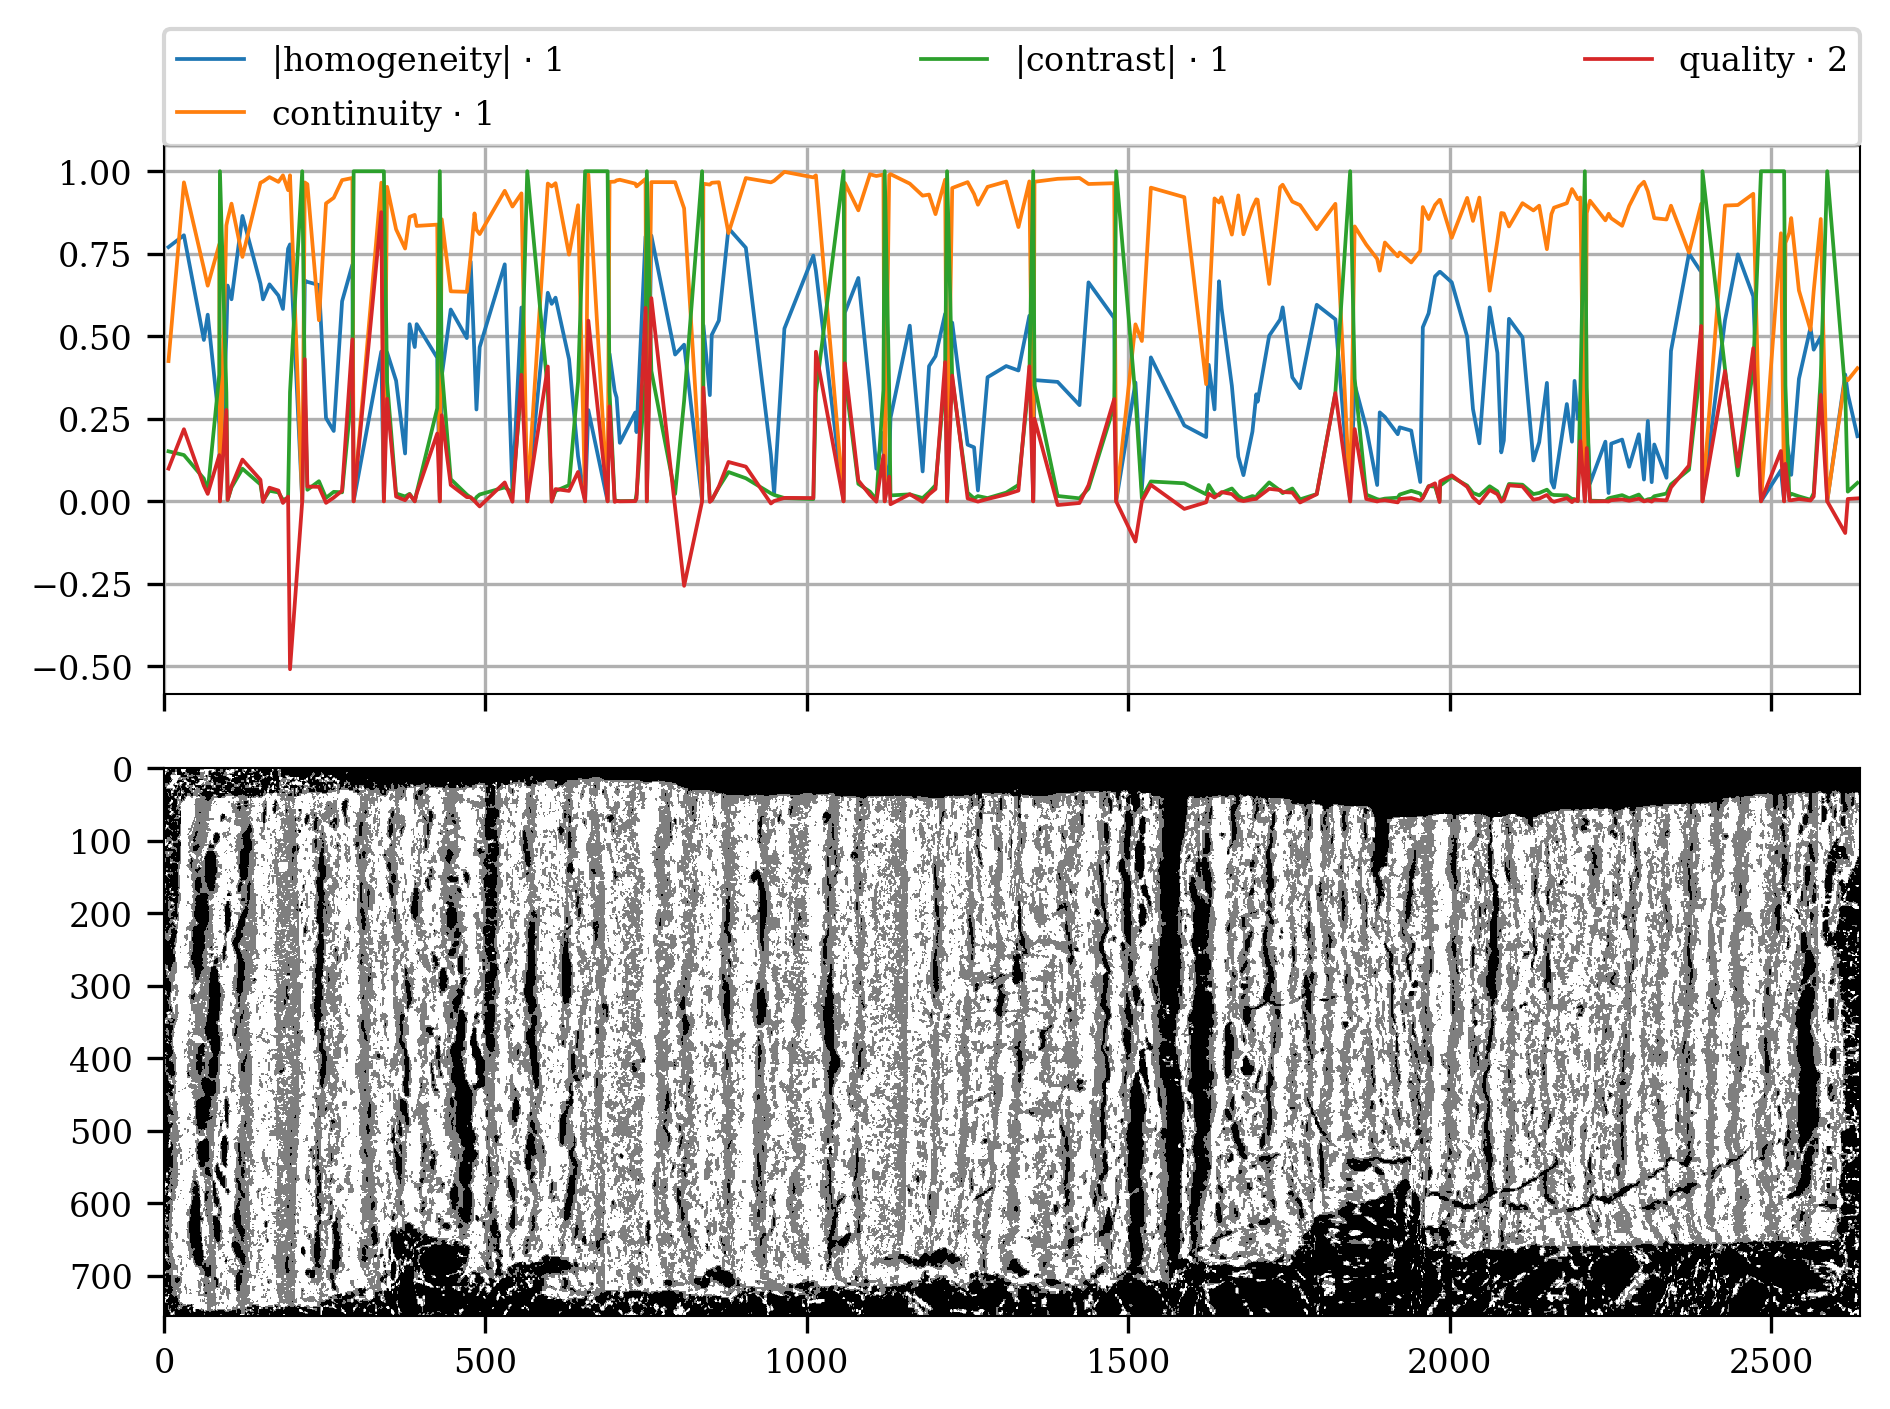

Setting simplified laminae: 100%|███████████████████████████████████████████████████| 200/200 [00:01<00:00, 182.88it/s]


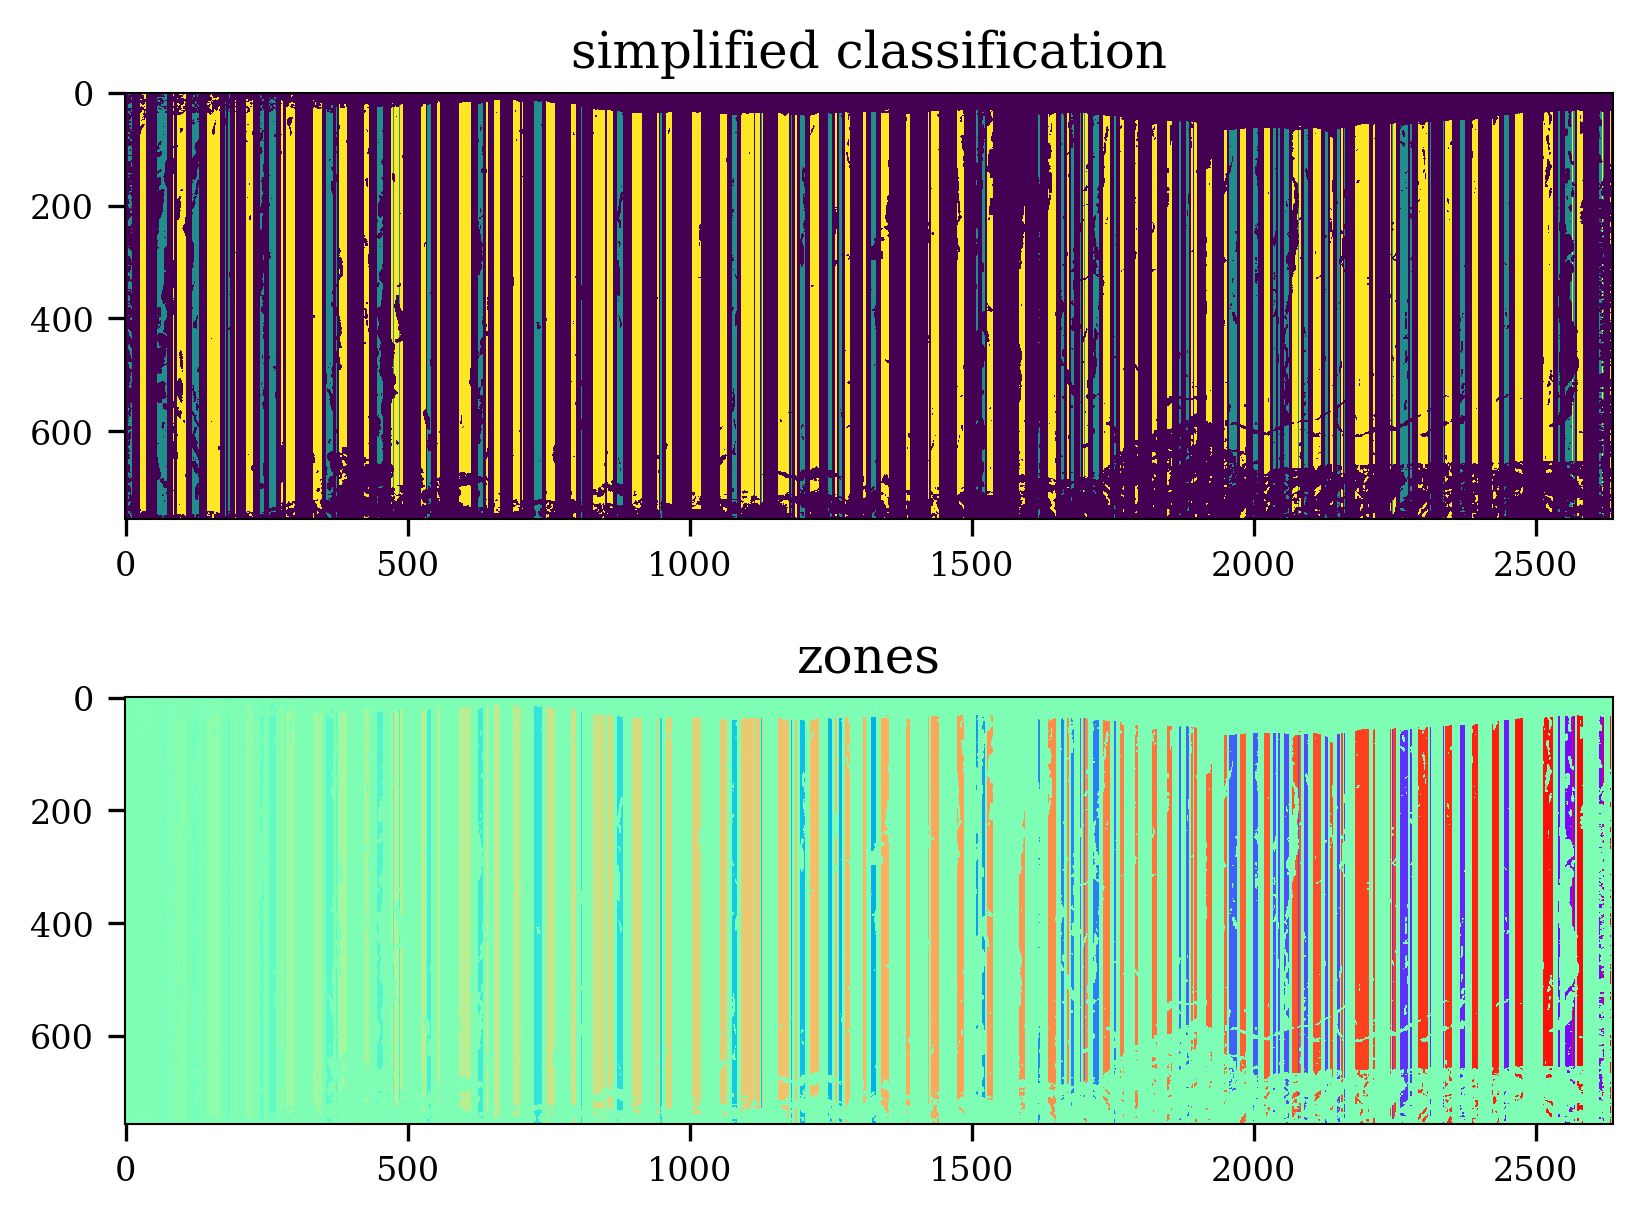

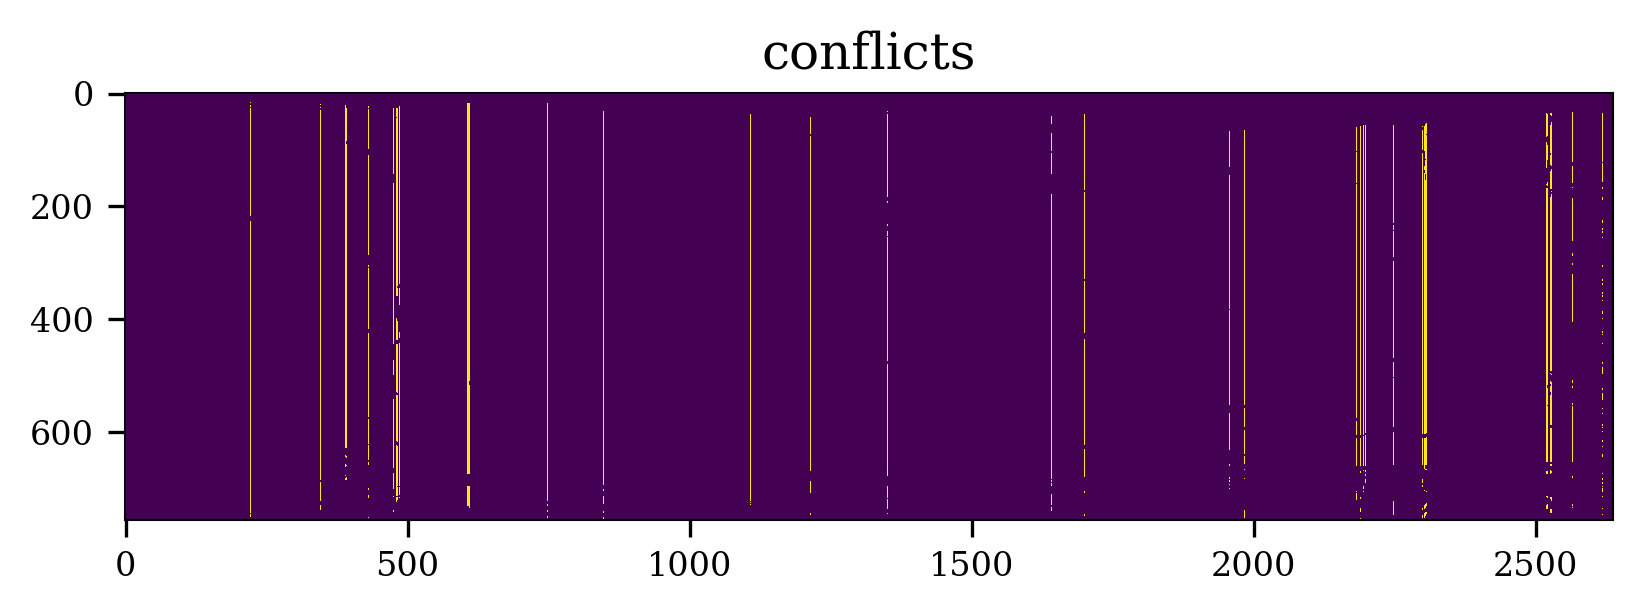

In [7]:
classified.reduce_laminae(n_expected=100, plts=True)

### Laminae quality
We haven't discussed what the quality score actually is and what it does. The idea is to quantify how pronounced the lamination in certain areas is and at the same time measure the goodness of the determined laminae (it is not possible to separate the two aspects because we don't know the true extent of layers). For this, we consider three criteria
* the *homogeneity*: how many pixels in the classified image belong to the right class (value range: \[0, 1\])
* the *continuity*: what fraction of pixels within a layer is sediment rather than background (value range: \[0, 1\])
* the *contrast*: how different the average luminosity within a layer is compared to its neighbors (value range: \[-1, 1\])
Those quantities are multiplied together for the *quality* score (value range: \[-1, 1\]). Let's see what this looks like:

Calculating layer qualities: 100%|███████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.23it/s]


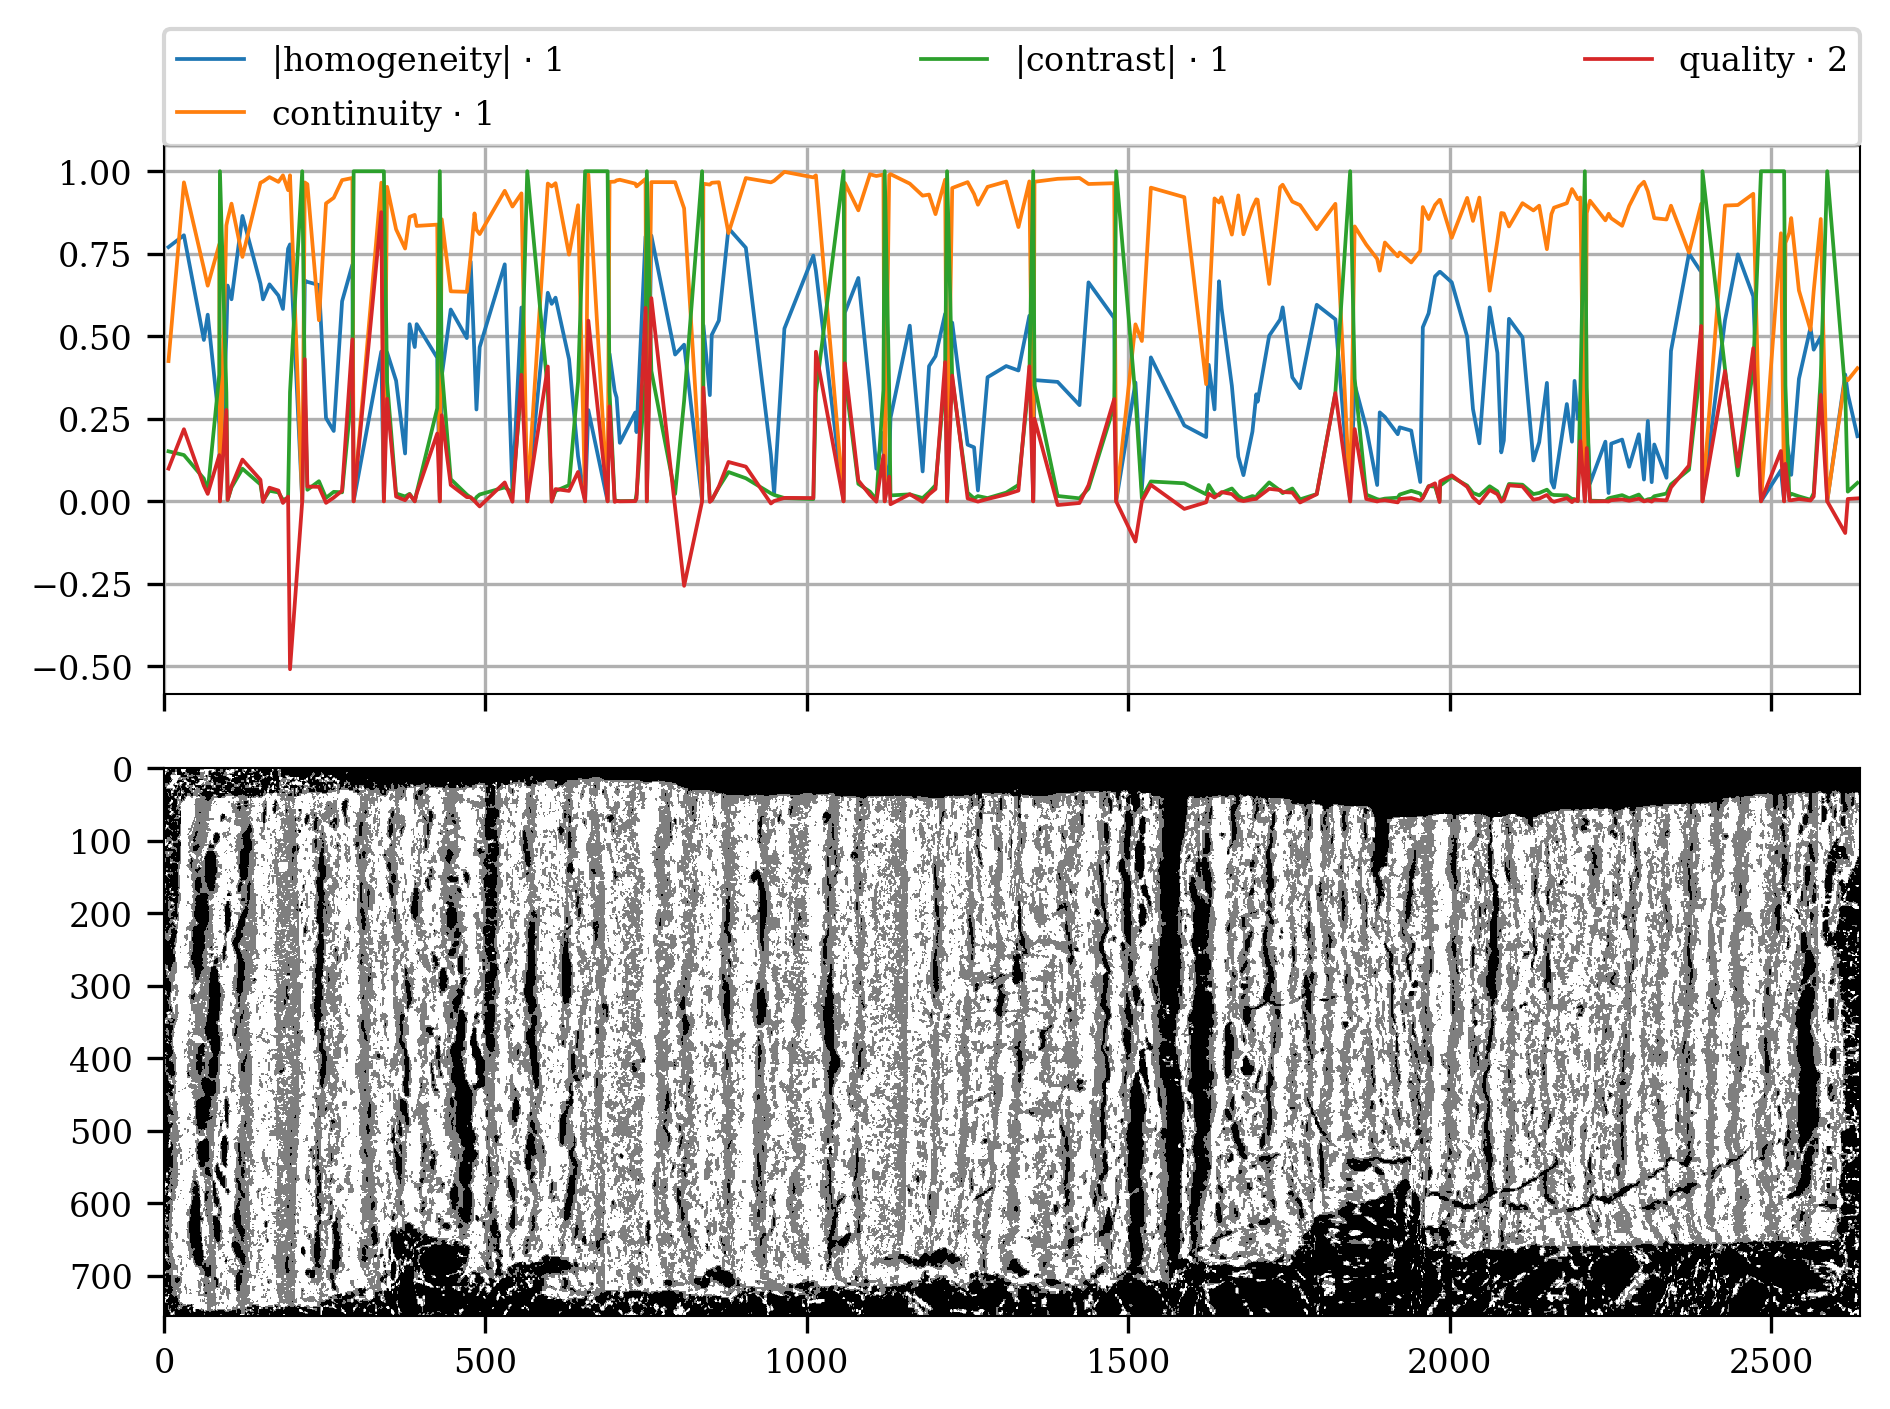

In [8]:
classified.set_quality_score()
classified.plot_quality()

### Reducing the number of laminae
The quality can be used to decide which layers to throw out. The `reduce` method first combines layers that are at the same seed (this can happen due to round-off imprecision) and then removes the layer with the lowest quality until the table contains the desired amount of laminae for each color.

In [9]:
classified.reduce_laminae(n_expected=100)

Since number of layers is too low, exiting method call.


In [10]:
classified.params_laminae_simplified

seed    a    b    c             d     height  success  color      width  \
0       7  0.0  0.0  0.0  5.394035e-03  13.575843    False   dark   8.524922   
1      31  0.0  0.0  0.0  2.449480e-03  25.649092    False  light  24.554190   
2      62  0.0  0.0  0.0  3.572790e-03   2.701029     True  light   5.402059   
3      68  0.0  0.0  0.0 -5.641161e-03  37.396175     True   dark  37.336307   
4      86  0.0  0.0  0.0 -9.345785e-04   3.430965     True  light   1.715483   
..    ...  ...  ...  ...           ...        ...      ...    ...        ...   
195  2577  0.0  0.0  0.0  5.651607e-03  19.653595    False  light  18.871687   
196  2587  0.0  0.0  0.0  0.000000e+00   0.903459     True   dark   0.903459   
197  2615  0.0  0.0  0.0  9.238128e-03  15.970760     True   dark  13.968050   
198  2619  0.0  0.0  0.0  1.431341e-03   1.082094     True  light   2.164187   
199  2634  0.0  0.0  0.0 -6.466960e-14   5.369036    False  light   4.130511   

     prominence  homogeneity  continuity  brightness  contrast   quality  \
0      0.103529    -0.770115    0.424861    0.439269 -0.151426  0.049545   
1      0.422139     0.806093    0.966308    0.596042  0.140163  0.109178   
2      0.071341    -0.488722    0.705570    0.459723 -0.068759  0.023710   
3      0.427350    -0.565375    0.653187    0.459181 -0.030382  0.011220   
4      0.023894     0.233933    0.778519    0.516191  0.384296  0.069988   
..          ...          ...         ...         ...       ...       ...   
195    0.263929     0.498868    0.855285    0.481781  0.377787  0.161192   
196    0.025341     0.000000    0.000000    0.000000 -1.000000 -0.000000   
197    0.176394    -0.384034    0.374160    0.455013  0.334472 -0.048060   
198    0.022649    -0.325758    0.366667    0.453849 -0.029324  0.003503   
199    0.068717     0.197256    0.403181    0.507527  0.055835  0.004441   

     sseed  
0       -7  
1       31  
2       62  
3      -68  
4       86  
..     ...  
195   2577  
196  -2587  
197  -2615  
198   2619  
199   2634  

[200 rows x 16 columns]

So our final classification looks like this

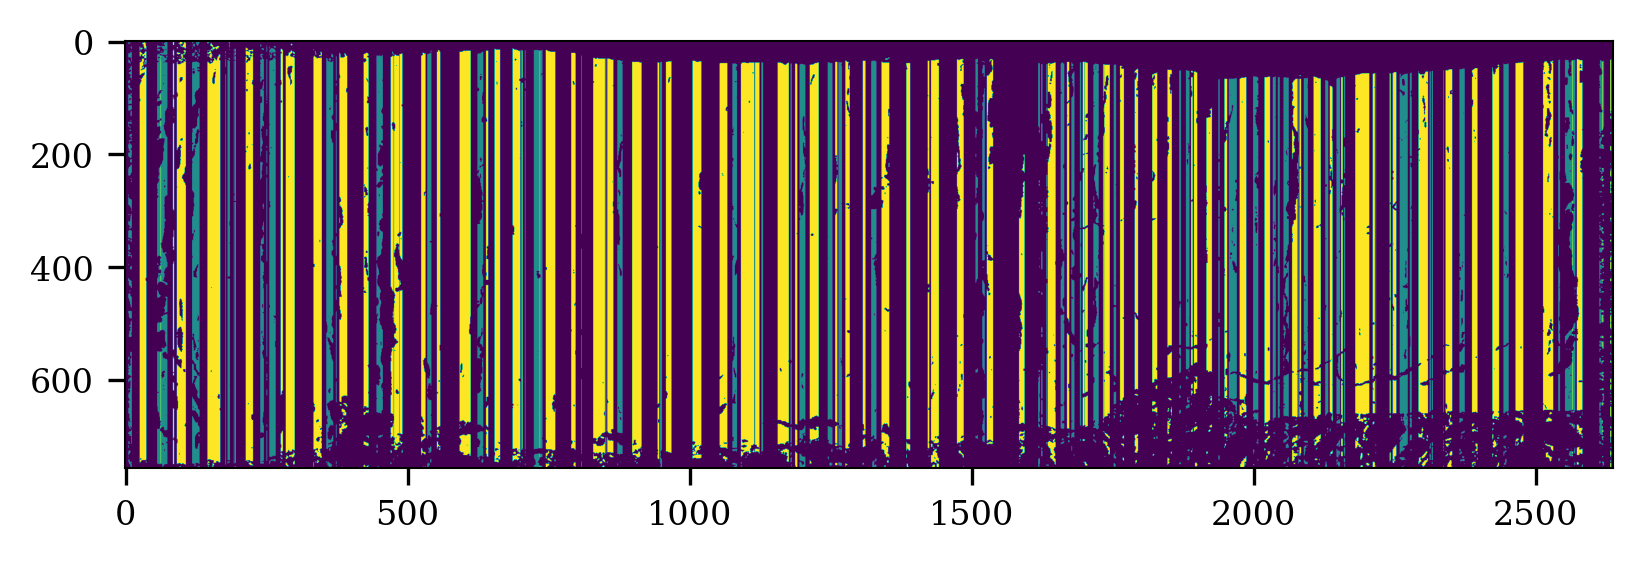

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(classified.get_image_simplified_classification())
plt.show()

or, if you prefere not to throw out any pixels

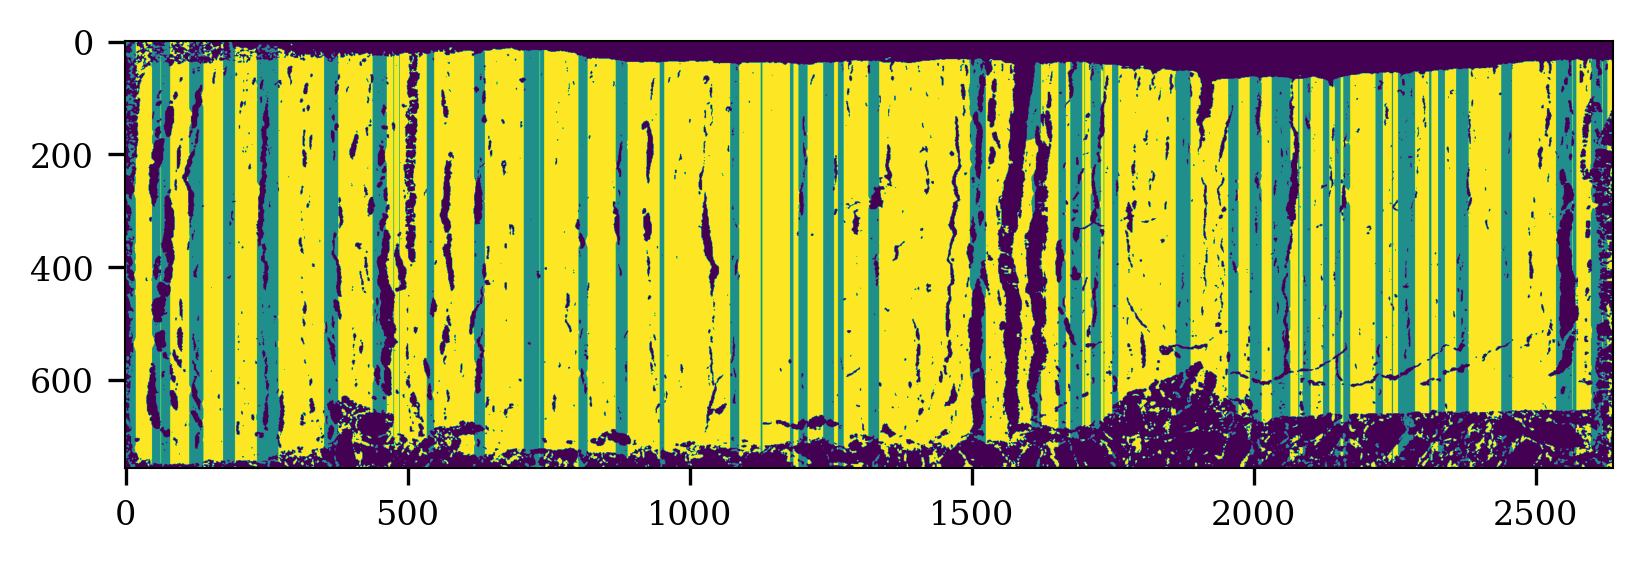

In [12]:
plt.imshow(classified.get_image_simplified_classification(True))
plt.show()

Admittedly, this is not perfect. But, considering that it required almost no manual labor (except for choosing a few parameters), it is a useful result. In the following sections, we will see how we can use this classification to reduce the ion images to time series. 